In [13]:
import torch
from torchvision.transforms.functional import resize, to_tensor, to_pil_image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.functional import mse_loss
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import datetime
import os
import sys

torch.cuda.empty_cache()


In [14]:

def debug(*args):
    print(*args, file=sys.stderr, flush=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.set_default_device(device)

MEAN = (0.485, 0.456, 0.406)
# image_path = "/path/to/your/image.jpg"

default_res = [32,64]


Using device: cuda


In [15]:

def to_img(tensor):
    t1 = tensor[0][:3].T.cpu().detach().numpy()
    t1 += MEAN
    t1 = t1.clip(0, 1)
    return np.transpose(t1, axes=(1, 0, 2))


def gramm(tnsr: torch.Tensor) -> torch.Tensor:
    """Computes Gram matrix for the input batch tensor.

    Args:
        tnsr (torch.Tensor): batch input tensor of shape [B, C, H, W].

    Returns:
        G (torch.Tensor): batch of gramm matrices of shape [B, C, C].
    """
    b, c, h, w = tnsr.size()
    F = tnsr.view(b, c, h * w)
    G = torch.bmm(F, F.transpose(1, 2))
    G.div_(h * w)
    return G


def prep_img_file(image: str, mean=MEAN):
    """Preprocess image.
    1) load as PIl
    3) convert to tensor
    5) remove alpha channel if any
    """
    im = Image.open(image)

    tensor = to_tensor(im).unsqueeze(0)
    if tensor.shape[1] == 4:
        # print("removing alpha chanel")
        tensor = tensor[:, :3, :, :]
    mean = torch.as_tensor(mean, dtype=tensor.dtype, device=tensor.device).view(
        -1, 1, 1
    )

    tensor.sub_(mean)
    # tensor.div_(0.25)
    return tensor


def gram_loss(input: torch.Tensor, gramm_target: torch.Tensor, weight: float = 1.0):
    """
    Computes MSE Loss for 2 Gram matrices input and target.

    Args:
        input (torch.Tensor): input tensor of shape [B, C, H, W].
        gramm_target (torch.Tensor): target tensor of shape [C, C].
        weight (float): weight for the loss. Default: 1.0.

    """
    G_target = gramm_target.repeat(input.size(0), 1, 1)
    # debug(G_target.shape)
    return weight * mse_loss(gramm(input), G_target)


def resize_and_tile_image(image: torch.Tensor, tile_shape: tuple, output_size: tuple):
    # Charger l'image
    # image = Image.open(image_path)

    # Redimensionner l'image
    image_resized = resize(image, tile_shape)

    # Convertir l'image redimensionnée en tensor
    image_resized_tensor = image_resized.unsqueeze(0)

    # Calculer le nombre de répétitions nécessaires
    repeat_x = output_size[0] // tile_shape[0] + 1
    repeat_y = output_size[1] // tile_shape[1] + 1

    # Dupliquer périodiquement l'image redimensionnée
    tiled_image_tensor = image_resized_tensor.repeat(1, 1, repeat_y, repeat_x)

    # Recadrer l'image dupliquée à la taille d'origine
    tiled_image_tensor = tiled_image_tensor[:, :, : output_size[1], : output_size[0]]
    return tiled_image_tensor



In [16]:

class MultiResLoss:
    def __init__(self, texture_path, resolutions=default_res) -> None:
        self.texture_path = texture_path
        self.resolutions = resolutions
        self.vgg = models.vgg19(weights="IMAGENET1K_V1").features.to(device)
        self.vgg.requires_grad_(False)
        self.extracted_layers_indexes = [1, 6, 11, 20, 29]
        self.layers_weights = [1 / n**2 for n in [64, 128, 256, 512, 512]]
        self.vgg_outputs = {}

        def save_output(name):

            # The hook signature
            def hook(module, module_in, module_out) -> None:
                self.vgg_outputs[name] = module_out

            return hook

        for layer in self.extracted_layers_indexes:
            handle = self.vgg[layer].register_forward_hook(save_output(layer))

        base_img = Image.open(texture_path)

        self.ref_img = prep_img_file(texture_path)[0].to(device)
        # debug(self.ref_img.shape)
        self.mutri_res_ref_imgs = [
            resize_and_tile_image(self.ref_img, (res, res), (128, 128))
            for res in resolutions
        ]
        # Charger les images
        images = [to_img(img.cpu()) for img in self.mutri_res_ref_imgs]

        # debug(images)
        # Créer une figure avec des sous-plots
        fig, axes = plt.subplots(1, len(images))

        # Afficher les images côte à côte
        if len(images) == 1:
            axes = [axes]

        for i, ax in enumerate(axes):
            ax.imshow(images[i])
            ax.axis("off")
        # Afficher la figure
        plt.show()

        self.ref_img_gramms_targets = []
        for img in self.mutri_res_ref_imgs:
            self.vgg(img / 0.25)
            self.ref_img_gramms_targets.append(
                [
                    gramm(self.vgg_outputs[layer])
                    for layer in self.extracted_layers_indexes
                ]
            )

    def compute_loss(self, partial_imgs: torch.Tensor):
        # partial_imgs est de la forme : nbr_res x batch_size x nbr_channels x res x res
        total_loss = torch.tensor(0.0).to(device)
        # debug(partial_imgs.shape)
        rgb_imgs = partial_imgs[:, :, :3, :, :]  # ne conserve que le RGB
        for i, res in enumerate(self.resolutions):
            res_total_loss = torch.tensor(0.0).to(device)
            res_batch = rgb_imgs[i]
            # debug(res_batch.shape)
            self.vgg(res_batch / 0.25)  # /0.25 ?
            vgg_of_res = [
                self.vgg_outputs[ind] for ind in self.extracted_layers_indexes
            ]
            # debug(len(vgg_of_res))
            # debug(vgg_of_res[0].shape)
            for node_val, gramm_target, layer_weight in zip(
                vgg_of_res, self.ref_img_gramms_targets[i], self.layers_weights
            ):
                # debug(node_val.shape, gramm_target.shape, layer_weight)
                layer_loss = gram_loss(node_val, gramm_target, layer_weight)
                res_total_loss = res_total_loss + layer_loss
            seuil = 5e-4
            if total_loss < seuil:
                total_loss = total_loss + res_total_loss
            # debug("loss for res", res, ":", res_total_loss.item())
        return total_loss  # faudra probablement clip la loss mais pour l'instant on dit que ça passe


In [17]:

class RecursiveNN(nn.Module):
    def __init__(
        self,
        loss,
        out_img_size=128,
        scales=default_res,
        iter_per_res=10,
        img_layer_depth=12,
        learning_rate=2e-4,
        bach_size=4,
    ):
        super(RecursiveNN, self).__init__()

        self.loss = loss
        self.img_size = out_img_size
        self.scales = scales
        self.downscale_nb = len(scales)
        self.img_layer_depth = img_layer_depth
        self.learning_rate = learning_rate
        self.bach_size = bach_size
        self.iter_per_res = iter_per_res

        self.ident = torch.tensor(
            [[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]
        ).to(device)
        self.sobel_x = torch.tensor(
            [[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]]
        ).to(device)
        self.lap = torch.tensor([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]]).to(
            device
        )

        self.couches = nn.ModuleList()  # contient des tuples : (conv1, conv2)

        # Création des couches
        for _ in range(self.downscale_nb):
            self.couches.append(
                nn.Sequential(
                    nn.Conv2d(
                        4 * img_layer_depth, 96, kernel_size=1, padding=0, stride=1
                    ).to(device),
                    nn.Conv2d(
                        96,
                        img_layer_depth,
                        kernel_size=1,
                        padding=0,
                        stride=1,
                        bias=False,
                    ).to(device),
                )
            )
        # debug(self.downscale_nb)
        # debug(self.couches)
        self.total_training_steps = 0
        self.total_params = sum(
            p.numel() for p in self.parameters()
        )  # pas sur que ça ai encore du sens

    def single_step(self, x, couche_ind):
        b, ch, h, w = x.shape
        filters = torch.stack([self.ident, self.sobel_x, self.sobel_x.T, self.lap]).to(
            device
        )

        y = x.reshape(b * ch, 1, h, w)

        y = torch.nn.functional.pad(y, [1, 1, 1, 1], "circular")
        y = torch.nn.functional.conv2d(y, filters[:, None])
        y = y.reshape(b, -1, h, w)

        cn1, cn2 = self.couches[couche_ind]
        out = cn2(F.relu(cn1(y)))

        return x + out

    def forward(self, x):
        b, ch, h, w = x.shape

        temps = torch.zeros(
            (self.downscale_nb, self.bach_size, self.img_layer_depth, h, w)
        ).to(device)
        temps[0] = x
        for i in range(self.downscale_nb):
            for _ in range(self.iter_per_res):
                temps[i] = self.single_step(temps[i], i)
            if i < self.downscale_nb - 1:
                factor = self.scales[i + 1] // self.scales[i]
                debug(temps[i].shape, factor)
                x_cropped = temps[
                    i,
                    :,
                    :,
                    : h // factor,
                    : w // factor,
                ]
                debug(x_cropped.shape)
                temps[i + 1] = F.interpolate(
                    x_cropped,
                    scale_factor=factor,
                    mode="bilinear",
                )

        return temps

    def render(self, it, width, height, save=True):

        x = torch.rand(
            size=(1, self.img_layer_depth, width, height), dtype=torch.float32
        ).to(device)
        with torch.no_grad():
            x = self(x)
            # besoin que d'une itération parce que les iter interne se font dans le forward

        # if save:
        #     plt.imsave(
        #         f"output/{datetime.datetime.now().strftime('%m-%d_%H-%M')}_{it}_iterations.png",
        #         to_img(x),
        #     )

    def start_training(self, nb_steps):
        optim = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        self.train()
        loss_history = []
        for i in range(nb_steps):
            current_batch = torch.rand(
                size=(
                    self.bach_size,
                    self.img_layer_depth,
                    self.img_size,
                    self.img_size,
                ),
                dtype=torch.float32,
                requires_grad=False,
            ).to(device)

            # debug("batch", current_batch.shape)

            outs = self(current_batch)
            outs_copy = outs.clone().detach()
            L = self.loss.compute_loss(outs)
            debug("Loss :", L.item())
            loss_history.append(L.item())
            with torch.no_grad():
                L.backward()
                for p in self.parameters():
                    p.grad /= p.grad.norm() + 1e-8  # normalize gradients
                optim.step()
                optim.zero_grad()

            # Display the images in outs
            if i % 100 == 0:
                if self.downscale_nb == 1:
                    img = to_img(outs[0].squeeze().cpu())
                    plt.imshow(img)
                    plt.axis("off")
                    plt.show()
                else:

                    fig, axs = plt.subplots(1, outs_copy.shape[0], figsize=(10, 10))
                    for i in range(outs_copy.shape[0]):
                        img = to_img(outs[i].squeeze().cpu())
                        axs[i].imshow(img)
                        axs[i].axis("off")
                    plt.show()


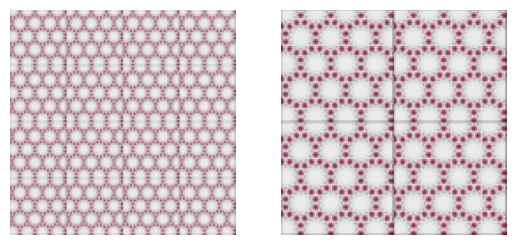

torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 11683431424.0


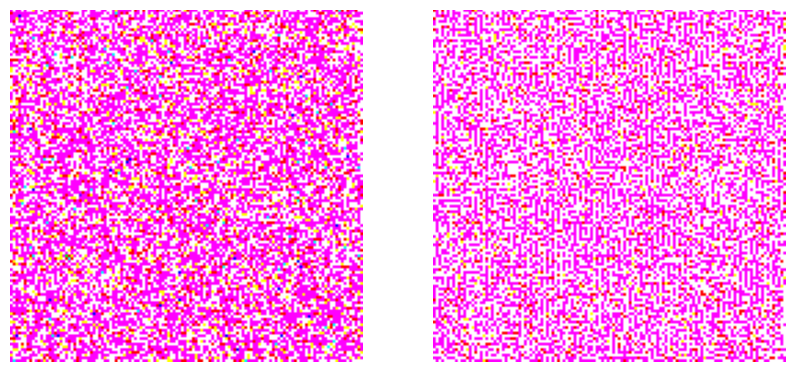

torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 6335196672.0
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 3341988352.0
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 1709402240.0
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 999585024.0
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 575845376.0
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 330284384.0
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 189804768.0
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 112948728.0
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 66686364.0
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 38591056.0


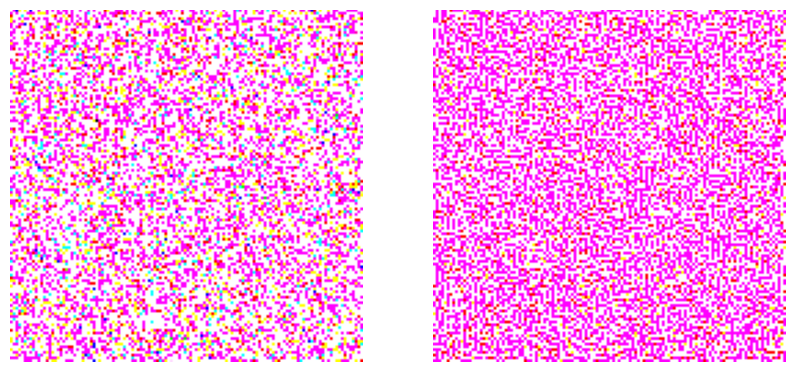

torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 24099522.0
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 14248667.0
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 8670536.0
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 5311318.5
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 3378645.25
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 2113133.5
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 1320401.375
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 829372.9375
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 523043.875
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 344462.03125


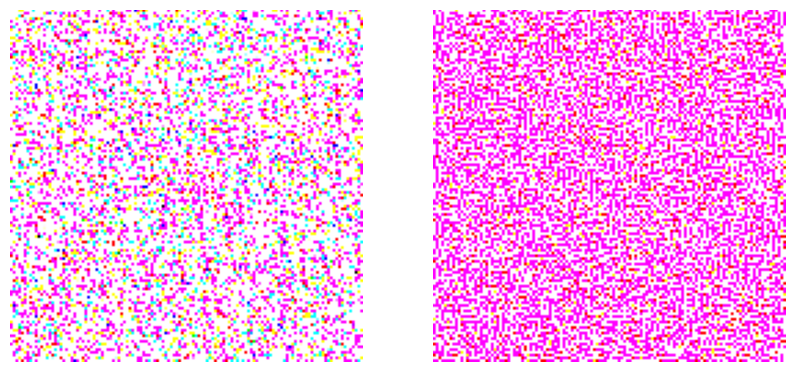

torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 209834.046875
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 130494.6640625
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 84584.203125
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 50702.4453125
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 32425.986328125
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 20591.927734375
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 13069.0791015625
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 8672.23828125
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 5280.81640625
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 3284.65283203125


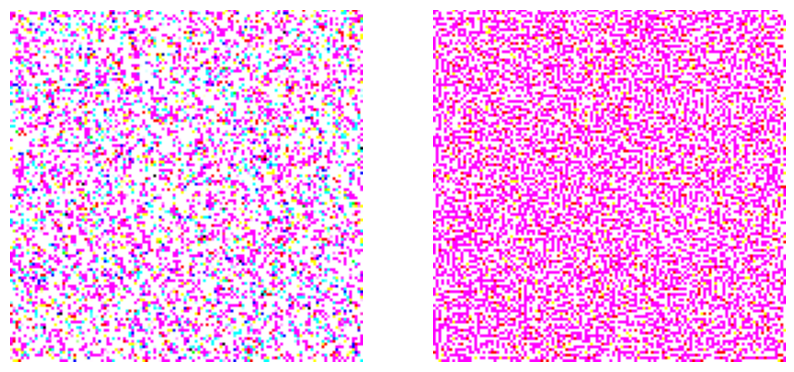

torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 2062.80517578125
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 1340.5550537109375
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 849.548583984375
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 531.318359375
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 336.2542419433594
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 224.43397521972656
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 138.98133850097656
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 89.70539093017578
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 57.876407623291016
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 38.594398498535156


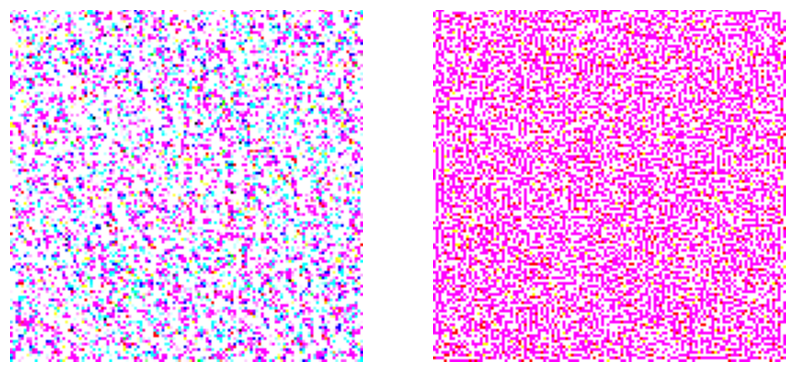

torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 24.645401000976562
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 16.45848846435547
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 10.909996032714844
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 7.035306930541992
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 4.80694580078125
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 3.0906143188476562
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 2.1239678859710693
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 1.4337583780288696
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 1.0026177167892456
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.684322714805603


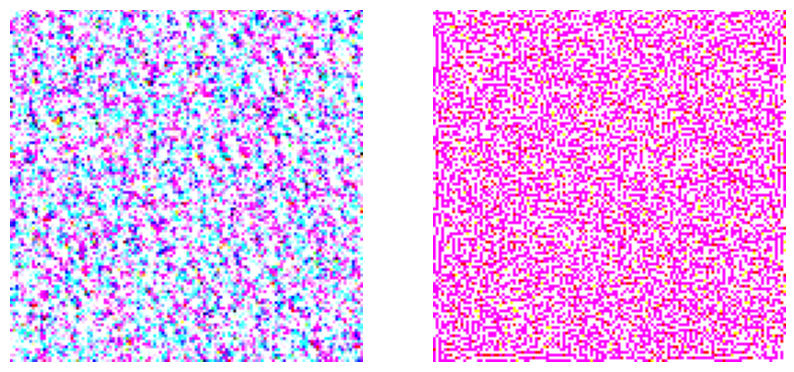

torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.46445655822753906
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.3234029710292816
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.225896954536438
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.1547459214925766
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.10735959559679031
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.07648070156574249
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.05844927951693535
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.0410807728767395
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.03128990903496742
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.022996732965111732


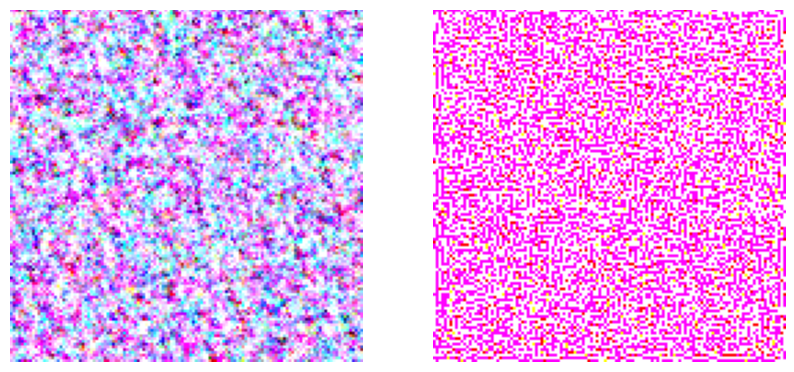

torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.017313767224550247
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.01290867105126381
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.01031196303665638
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.008432677946984768
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.006817917339503765
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.005876910872757435
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.004908832721412182
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.0043732342310249805
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.0038772467523813248
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.0035894238390028477


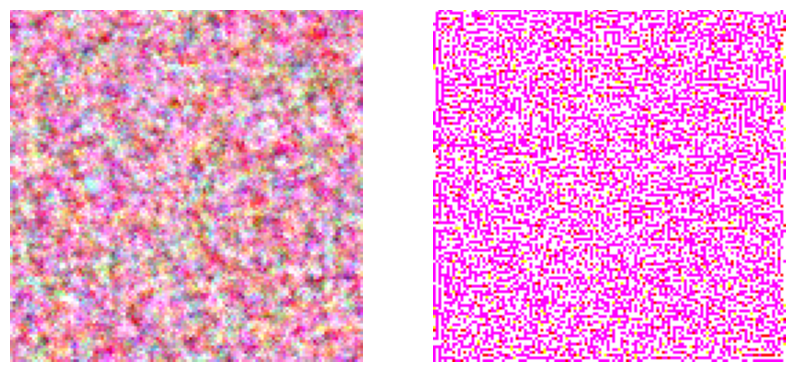

torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.003472849726676941
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])
Loss : 0.003205269807949662
torch.Size([4, 12, 128, 128]) 2
torch.Size([4, 12, 64, 64])


KeyboardInterrupt: 

In [18]:
image_path = "test.png"
loss = MultiResLoss(image_path)
model = RecursiveNN(loss)
model.start_training(1000)
